In [60]:
import os
from ultralytics import YOLO
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from tabulate import tabulate

def load_labels(label_path):
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
        return [list(map(float, line.strip().split())) for line in lines]
    except FileNotFoundError:
        print(f"Warning: Label file not found: {label_path}")
        return []

def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

def evaluate_predictions(ground_truth, predictions, iou_threshold=0.5):
    matched_gt = set()
    true_positives = 0
    false_positives = 0
    
    for pred in predictions:
        best_iou = 0
        best_gt = None
        for i, gt in enumerate(ground_truth):
            if i in matched_gt:
                continue
            iou = calculate_iou(pred[1:], gt[1:])
            if iou > best_iou:
                best_iou = iou
                best_gt = i
        
        if best_iou > iou_threshold:
            true_positives += 1
            matched_gt.add(best_gt)
        else:
            false_positives += 1
    
    false_negatives = len(ground_truth) - len(matched_gt)
    
    return true_positives, false_positives, false_negatives
def main():
    model_path = '/Users/yshokrollahi/Desktop/MD/Project4/runs/dataset-val-2000/weights/best.pt'
    val_images_dir = '/Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images'
    val_labels_dir = '/Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/labels'
    
    model = YOLO(model_path)
    
    all_true_positives = 0
    all_false_positives = 0
    all_false_negatives = 0
    
    image_metrics = []
    
    for img_name in tqdm(os.listdir(val_images_dir)):
        if img_name.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(val_images_dir, img_name)
            label_path = os.path.join(val_labels_dir, os.path.splitext(img_name)[0] + '.txt')
            
            try:
                # Run prediction
                results = model.predict(img_path, save=False, imgsz=640, conf=0.5, max_det=5000)
                
                # Get predictions
                predictions = results[0].boxes.xywhn.cpu().numpy()
                confidences = results[0].boxes.conf.cpu().numpy()
                predictions = [np.append(conf, pred) for conf, pred in zip(confidences, predictions)]
                
                # Load ground truth
                ground_truth = load_labels(label_path)
                
                # Evaluate
                tp, fp, fn = evaluate_predictions(ground_truth, predictions)
                
                all_true_positives += tp
                all_false_positives += fp
                all_false_negatives += fn
                
                # Calculate metrics for this image
                precision = tp / (tp + fp) if tp + fp > 0 else 0
                recall = tp / (tp + fn) if tp + fn > 0 else 0
                f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
                
                image_metrics.append([img_name, precision, recall, f1_score, tp, fp, fn])
                
            except Exception as e:
                print(f"Error processing {img_name}: {str(e)}")
    
    # Calculate overall metrics
    overall_precision = all_true_positives / (all_true_positives + all_false_positives) if all_true_positives + all_false_positives > 0 else 0
    overall_recall = all_true_positives / (all_true_positives + all_false_negatives) if all_true_positives + all_false_negatives > 0 else 0
    overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if overall_precision + overall_recall > 0 else 0
    
    # Add overall metrics to the table
    image_metrics.append(["Overall", overall_precision, overall_recall, overall_f1_score, all_true_positives, all_false_positives, all_false_negatives])
    
    # Create and print the table
    headers = ["Image", "Precision", "Recall", "F1 Score", "TP", "FP", "FN"]
    print(tabulate(image_metrics, headers=headers, floatfmt=".4f"))

if __name__ == "__main__":
    main()


  0%|                                                    | 0/16 [00:00<?, ?it/s]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/RSCC_PATCH_3.png: 640x640 45 cd45s, 2044 panCKs, 47 Otherss, 614.8ms
Speed: 0.9ms preprocess, 614.8ms inference, 20.9ms postprocess per image at shape (1, 3, 640, 640)


  6%|██▊                                         | 1/16 [00:17<04:19, 17.27s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/PUC_PATCH_1.png: 640x640 41 cd45s, 911 panCKs, 120 Otherss, 612.2ms
Speed: 1.0ms preprocess, 612.2ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 640)


 12%|█████▌                                      | 2/16 [00:20<02:10,  9.29s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/RSCC_PATCH_1.png: 640x640 46 cd45s, 2390 panCKs, 49 Otherss, 697.7ms
Speed: 0.9ms preprocess, 697.7ms inference, 34.1ms postprocess per image at shape (1, 3, 640, 640)


 19%|████████▎                                   | 3/16 [00:45<03:30, 16.17s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/PUC_PATCH_2.png: 640x640 20 cd45s, 519 panCKs, 40 Otherss, 758.3ms
Speed: 1.4ms preprocess, 758.3ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)


 25%|███████████                                 | 4/16 [00:46<02:05, 10.44s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/UC_PATCH_4.png: 640x640 62 cd45s, 222 panCKs, 11 Otherss, 679.6ms
Speed: 0.9ms preprocess, 679.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 38%|████████████████▌                           | 6/16 [00:47<00:51,  5.15s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/UC_PATCH_3.png: 640x640 61 cd45s, 307 panCKs, 9 Otherss, 655.7ms
Speed: 0.8ms preprocess, 655.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|███████████████████▎                        | 7/16 [00:48<00:36,  4.03s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/UC_PATCH_2.png: 640x640 58 cd45s, 879 panCKs, 97 Otherss, 633.2ms
Speed: 0.8ms preprocess, 633.2ms inference, 9.9ms postprocess per image at shape (1, 3, 640, 640)


 50%|██████████████████████                      | 8/16 [00:52<00:32,  4.02s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/PSCC_PATCH_1.png: 640x640 287 panCKs, 595.0ms
Speed: 0.8ms preprocess, 595.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 56%|████████████████████████▊                   | 9/16 [00:53<00:21,  3.10s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/UC_PATCH_1.png: 640x640 16 cd45s, 1284 panCKs, 13 Otherss, 556.9ms
Speed: 0.7ms preprocess, 556.9ms inference, 13.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████████████████████████▉                | 10/16 [00:59<00:22,  3.77s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/PSCC_PATCH_2.png: 640x640 325 panCKs, 9 Otherss, 551.1ms
Speed: 0.8ms preprocess, 551.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 69%|█████████████████████████████▌             | 11/16 [01:00<00:14,  2.93s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/CC_PATCH_2.png: 640x640 70 cd45s, 381 panCKs, 879 Otherss, 544.7ms
Speed: 0.7ms preprocess, 544.7ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)


 75%|████████████████████████████████▎          | 12/16 [01:05<00:15,  3.80s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/CC_PATCH_1.png: 640x640 101 cd45s, 272 panCKs, 755 Otherss, 553.6ms
Speed: 0.8ms preprocess, 553.6ms inference, 11.8ms postprocess per image at shape (1, 3, 640, 640)


 81%|██████████████████████████████████▉        | 13/16 [01:10<00:11,  3.87s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/CC_PATCH_4.png: 640x640 31 cd45s, 637 panCKs, 256 Otherss, 540.7ms
Speed: 0.8ms preprocess, 540.7ms inference, 9.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|█████████████████████████████████████▋     | 14/16 [01:13<00:07,  3.86s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/CC_PATCH_6.png: 640x640 13 cd45s, 559 panCKs, 16 Otherss, 563.6ms
Speed: 0.8ms preprocess, 563.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|████████████████████████████████████████▎  | 15/16 [01:15<00:03,  3.14s/it]


image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/CC_PATCH_7.png: 640x640 8 cd45s, 556 panCKs, 4 Otherss, 549.9ms
Speed: 0.7ms preprocess, 549.9ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


100%|███████████████████████████████████████████| 16/16 [01:16<00:00,  4.79s/it]

Image               Precision    Recall    F1 Score     TP    FP    FN
----------------  -----------  --------  ----------  -----  ----  ----
RSCC_PATCH_3.png       0.9541    0.8014      0.8711   2038    98   505
PUC_PATCH_1.png        0.9226    0.9183      0.9204    989    83    88
RSCC_PATCH_1.png       0.9421    0.7992      0.8648   2341   144   588
PUC_PATCH_2.png        0.9016    0.9288      0.9150    522    57    40
UC_PATCH_4.png         0.9186    0.9281      0.9233    271    24    21
UC_PATCH_3.png         0.9284    0.9259      0.9272    350    27    28
UC_PATCH_2.png         0.9188    0.8528      0.8845    950    84   164
PSCC_PATCH_1.png       0.9617    0.9684      0.9650    276    11     9
UC_PATCH_1.png         0.8873    0.8642      0.8756   1165   148   183
PSCC_PATCH_2.png       0.9192    0.8457      0.8809    307    27    56
CC_PATCH_2.png         0.9316    0.8676      0.8985   1239    91   189
CC_PATCH_1.png         0.9238    0.9100      0.9168   1042    86   103
CC_PAT


Processing image: PSCC_PATCH_1.png

image 1/1 /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images/PSCC_PATCH_1.png: 640x640 287 panCKs, 542.8ms
Speed: 0.8ms preprocess, 542.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Model predicted 287 points
Loaded 285 labels from /Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/labels/PSCC_PATCH_1.txt
True Positives: 265
False Positives: 22
False Negatives: 20
Precision: 0.9233
Recall: 0.9298
F1 Score: 0.9266
Plotted 285 points
Plotted 287 points


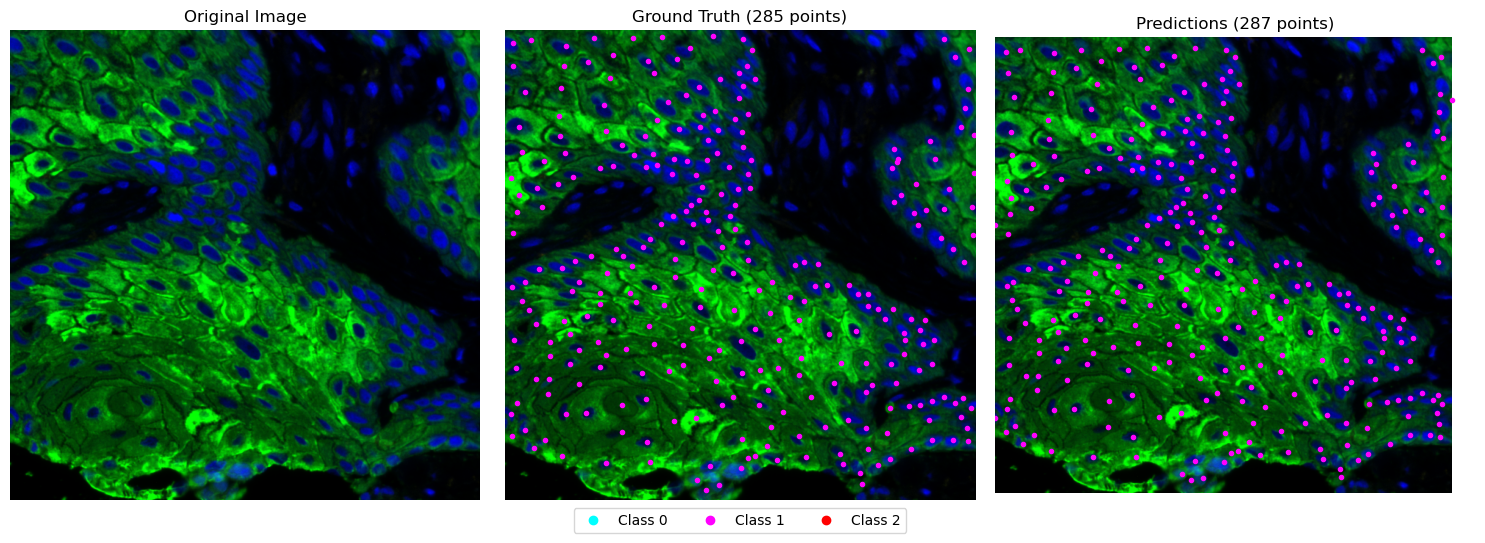

In [3]:
import os
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Color mapping for classes
colors = {
    0: '#00ffff',  # cyan for class 0 (cd45)
    1: '#ff00ff',  # magenta for class 1 (panCK)
    2: '#ff0000'   # red for class 2 (Others)
}

def load_labels(label_path):
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
        labels = [list(map(float, line.strip().split())) for line in lines]
        print(f"Loaded {len(labels)} labels from {label_path}")
        return labels
    except FileNotFoundError:
        print(f"Warning: Label file not found: {label_path}")
        return []

def evaluate_predictions(ground_truth, predictions, distance_threshold=0.01):
    matched_gt = set()
    true_positives = 0
    false_positives = 0
    
    for pred in predictions:
        best_distance = float('inf')
        best_gt = None
        for i, gt in enumerate(ground_truth):
            if i in matched_gt:
                continue
            distance = np.sqrt((pred[1] - gt[1])**2 + (pred[2] - gt[2])**2)
            if distance < best_distance:
                best_distance = distance
                best_gt = i
        
        if best_distance < distance_threshold:
            true_positives += 1
            matched_gt.add(best_gt)
        else:
            false_positives += 1
    
    false_negatives = len(ground_truth) - len(matched_gt)
    
    return true_positives, false_positives, false_negatives

def adjust_point(x, y, width, height, threshold=0.01):
    # Adjust point if close to boundary
    if x < threshold * width:
        x = 0
    elif x > (1 - threshold) * width:
        x = width
    if y < threshold * height:
        y = 0
    elif y > (1 - threshold) * height:
        y = height
    return x, y

def plot_points(ax, points, image_shape, boundary_threshold=0.02):
    height, width = image_shape[:2]
    for point in points:
        class_id, x_center, y_center, _ = int(point[0]), point[1], point[2], point[3]
        x = x_center * width
        y = y_center * height
        # Adjust points near the boundary
        x, y = adjust_point(x, y, width, height, threshold=boundary_threshold)
        color = colors.get(class_id, '#ffffff')  # default to white if class not found
        ax.plot(x, y, 'o', color=color, markersize=3)
    print(f"Plotted {len(points)} points")

def visualize_results(img_path, ground_truth, predictions, boundary_threshold=0.02):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not read image at {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original Image
    ax1.imshow(img)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    # Ground Truth
    ax2.imshow(img)
    plot_points(ax2, ground_truth, img.shape, boundary_threshold=0)
    ax2.set_title(f"Ground Truth ({len(ground_truth)} points)")
    ax2.axis('off')
    
    # Predictions
    ax3.imshow(img)
    plot_points(ax3, predictions, img.shape, boundary_threshold)
    ax3.set_title(f"Predictions ({len(predictions)} points)")
    ax3.axis('off')
    
    # Add color legend
    handles = [plt.plot([], [], 'o', color=color, label=f'Class {class_id}')[0] for class_id, color in colors.items()]
    fig.legend(handles=handles, loc='lower center', ncol=len(colors), bbox_to_anchor=(0.5, -0.05))
    
    plt.tight_layout()
    plt.show()

def main():
    model_path = '/Users/yshokrollahi/Desktop/MD/Project4/runs/dataset-val-2000/weights/best.pt'
    val_images_dir = '/Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/images'
    val_labels_dir = '/Users/yshokrollahi/Desktop/MD/Project4/Dataset/val_pack/labels'
    
    # Specify the image you want to process
    img_name = "PSCC_PATCH_1.png"
    
    img_path = os.path.join(val_images_dir, img_name)
    label_path = os.path.join(val_labels_dir, os.path.splitext(img_name)[0] + '.txt')
    
    model = YOLO(model_path)
    
    try:
        print(f"\nProcessing image: {img_name}")
        
        # Run prediction
        results = model.predict(img_path, save=False, imgsz=640, conf=0.5, max_det=5000)
        
        # Get predictions
        predictions = results[0].boxes.xywhn.cpu().numpy()
        confidences = results[0].boxes.conf.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()
        predictions = [np.array([cls, pred[0], pred[1], conf]) for cls, pred, conf in zip(classes, predictions, confidences)]
        print(f"Model predicted {len(predictions)} points")
        
        # Load ground truth
        ground_truth = load_labels(label_path)
        
        # Evaluate predictions
        true_positives, false_positives, false_negatives = evaluate_predictions(ground_truth, predictions)
        
        # Calculate metrics
        if true_positives + false_positives > 0:
            precision = true_positives / (true_positives + false_positives)
        else:
            precision = 0
        
        if true_positives + false_negatives > 0:
            recall = true_positives / (true_positives + false_negatives)
        else:
            recall = 0
        
        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0
        
        # Print metrics
        print(f"True Positives: {true_positives}")
        print(f"False Positives: {false_positives}")
        print(f"False Negatives: {false_negatives}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        
        # Visualize results
        visualize_results(img_path, ground_truth, predictions, boundary_threshold=0.02)
        
    except Exception as e:
        print(f"Error processing {img_name}: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()
